In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Test Utilities 

## Model generation 

In [3]:
dim_triu = dim * (dim + 1) // 2

In [4]:
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def build_model(activation, structure, learning_rate):



    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

    # hidden
    for layer in structure:

        model.add(keras.layers.Dense(
                layer, 
                activation=activation, 
                kernel_initializer=intializer, 
                #bias_initializer='zeros',
                #kernel_regularizer=keras.regularizers.l2(1e-8)
        ))


    #output
    model.add(keras.layers.Dense(dim_triu))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])
    
    return model

## Training 

In [5]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=50, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-5, 
    cooldown=10, 
    min_lr=1e-10
)

In [6]:
n_tests = 10
n_resets = 4
epochs = 10000


def test_model(structure, activation, learning_rate=1e-4):
    error = []
    
    for i in range(n_tests):
        
        keras.backend.clear_session()
        model = build_model(activation, structure, learning_rate)
        
        for j in range(n_resets):
            keras.backend.set_value(model.optimizer.lr, learning_rate)
            
            history = model.fit(
                x = s_train,
                y = p_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(s_test, p_test), 
                verbose=0, 
                callbacks=[
                    early_stopping, 
                    reduce_lr
                ]
            )
        
        error.append(np.min(history.history["val_mean_absolute_error"]))
        
        print(" - Test " + str(i+1) + ": " + str(error[-1]))
    
    return error

def run_layer_test_series(activation, structures, learning_rate):
    error = []
    for structure in structures:
        print("Layers: " + str(structure))
        error.append(test_model(structure, activation, learning_rate=learning_rate))
    return error

# Testing 

In [7]:
structures = [
        [dim_triu, dim_triu],
        [dim_triu, dim_triu, dim_triu],
        [dim_triu + 100, dim_triu + 100],
        [dim_triu + 250, dim_triu + 150, dim_triu + 50],
        [dim_triu + 100, dim_triu + 200, dim_triu + 100],
        [dim_triu, dim_triu, dim_triu, dim_triu, dim_triu]
    ]
        
learning_rates = [1e-3, 1e-4, 1e-5]

In [8]:
res = []
for lr in learning_rates:
    print("# lr" + str(lr))
    res.append(run_layer_test_series('elu', structures, lr))

# lr0.001
Layers: [351, 351]

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00121: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00140: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00255: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-0


Epoch 00122: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00255: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00278: early stopping
 - Test 2: 0.004277152657990728

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00113: ReduceLROnPlateau reducing lear


Epoch 00261: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00304: early stopping

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-0


Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00281: early stopping

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.000500000023748725


Epoch 00195: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00299: early stopping

Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00104: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-0


Epoch 00316: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00332: early stopping

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00255: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07


Epoch 00151: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00212: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00231: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00250: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00269: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00288: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00307: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00326: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00330: early stopping

Epoch 00133: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.000250000011874362


Epoch 00260: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00305: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00324: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00343: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00381: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00419: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00438: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00457: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00476: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00495: ReduceLROnP

Epoch 00417: early stopping

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00278: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00316: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00335: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07


Epoch 00350: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00357: early stopping

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


Epoch 00250: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00269: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00280: early stopping
 - Test 8: 0.060720779687462756

Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00155: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00174: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00193: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00276: ReduceLROnPlateau reducing learn


Epoch 00314: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00333: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00352: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.

Epoch 00371: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
Epoch 00372: early stopping

Epoch 00124: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00319: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00395: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00414: ReduceLROnP


Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 00277: early stoppin


Epoch 00110: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00310: early stopping

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.000500000023748725


Epoch 00205: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00319: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00329: early stopping
 - Test 7: 0.005322537978008315

Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00156: ReduceLROnPlateau reducing learni


Epoch 00282: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00292: early stopping

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00246: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07


Epoch 00929: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00948: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00967: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.

Epoch 00986: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.

Epoch 01005: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.
Epoch 01012: early stopping

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


Epoch 00395: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00414: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00433: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 00437: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06


Epoch 00378: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00397: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00418: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00437: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00456: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00475: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00494: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00513: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00532: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00540: early stopping

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.00012500000593718


Epoch 00182: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00267: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00305: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00324: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00343: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00381: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00419: ReduceLROnP


Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00216: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00235: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00292: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00311: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00330: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 00360: early stopping

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.00025000001187436


Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 00179: early stopping
 - Test 10: 0.060567964090784986
Layers: [451, 551, 451]

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00104: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00184: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00203: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00241: ReduceLRO


Epoch 00148: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 00254: early stopping
 - Test 2: 0.060655564736964096

Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00155: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00174: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00193: ReduceLROnPlateau reducing learnin


Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 00163: early stopping

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 00628: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00165: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00184: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00203: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 00234: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning ra


Epoch 00328: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00385: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00404: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.

Epoch 00423: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
Epoch 00429: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00428: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00465: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00484: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00503: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00522: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05


Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00150: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00270: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00308: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00327: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00338: early stoppi


Epoch 00195: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 00238: early stopping
 - Test 1: 0.06061512550607843

Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00293: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00312: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00331: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00350: ReduceLROnPlateau reducing learning


Epoch 00216: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00235: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 00238: early stopping
 - Test 3: 0.06067159493912512

Epoch 00120: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00319: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00357: ReduceLROnPlateau reducing learning


Epoch 00200: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00333: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00352: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00371: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00390: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00428: ReduceLROnP


Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00333: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00352: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00371: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00390: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00417: early stoppi


Epoch 00204: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 00222: early stopping
 - Test 9: 0.06059055395461434

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00298: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00317: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00336: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00355: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00393: ReduceLROnPlateau reducing learning


Epoch 00343: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00381: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.

Epoch 00419: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
Epoch 00429: early stopping

Epoch 00056: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00113: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

E


Epoch 00385: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00404: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00423: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00426: early stopping

Epoch 00029: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.



Epoch 00413: early stopping

Epoch 00033: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00090: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

E


Epoch 00111: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00168: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00206: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00225: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00237: early stopping

Epoch 00027: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epo


Epoch 00235: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00264: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.




Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00244: early stopping

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

E


Epoch 00160: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 00216: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00111: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00168: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

E


Epoch 00200: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00223: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00111: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00168: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Ep


Epoch 00076: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00190: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 00200: early stopping
 - Test 8: 0.004930023066884843

Epoch 00263: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00282: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00322: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00341: ReduceLROnPlateau reducing learning rat


Epoch 00138: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00218: early stopping
 - Test 10: 0.0049106880642510765
Layers: [451, 451]

Epoch 00179: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00283: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00302: ReduceLROnPlateau


Epoch 00130: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00234: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00253: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00272: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00291: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00310: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00348: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00367: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00386: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00405: ReduceLROnPlatea


Epoch 00232: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00270: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00308: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00327: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00346: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00365: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00384: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00399: early stopping

Epoch 00032: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

E


Epoch 00344: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00363: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00382: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00401: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00420: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00431: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00081: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00100: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.



Epoch 00412: early stopping

Epoch 00044: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00215: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00234: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00253: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Ep

Epoch 00447: early stopping

Epoch 00036: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00150: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Ep


Epoch 00131: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00150: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00235: early stopping

Epoch 00026: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epo


Epoch 00172: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00242: early stopping

Epoch 00023: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Ep


Epoch 00200: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00260: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

E


Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00237: early stopping

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

E


Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00236: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

E


Epoch 00109: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00128: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 00220: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00121: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoc


Epoch 00153: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00216: early stopping

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Ep


Epoch 00194: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00255: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

E


Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00215: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00219: early stopping
 - Test 9: 0.0048157955631057715

Epoch 00236: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00258: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00277: ReduceLROnPlateau reducing learning r

Epoch 00295: early stopping

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00226: early stopping
 - Test 1: 0.006238836769607678

Epoch 00016: ReduceLROn


Epoch 00338: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00395: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00414: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00433: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00452: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00471: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00482: early stopping

Epoch 00033: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

E

Epoch 00698: early stopping

Epoch 00023: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00126: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00164: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00227: early stopping

Epoch 00025: ReduceLROnPlateau reducing learning rate t


Epoch 00204: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00281: early stopping

Epoch 00048: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.




Epoch 00157: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
Epoch 00350: early stopping

Epoch 00035: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.



Epoch 00809: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00207: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate t


Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00214: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

E


Epoch 00112: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00150: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00215: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00111: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epo


Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00202: early stopping
 - Test 7: 0.010602113406234119

Epoch 00592: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00611: ReduceLROnPlateau reducing learning ra


Epoch 00192: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.
Epoch 00210: early stopping
 - Test 9: 0.010582484694114372

Epoch 00595: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00614: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00633: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00652: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00671: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00690: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00709: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00728: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00747: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00766: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00785: ReduceLROnPlateau reducing learning ra


Epoch 00862: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00881: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00900: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00919: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00938: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00957: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00976: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00995: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 01014: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 01033: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.
Epoch 01036: early stopping

Epoch 00029: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.




Epoch 01026: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 01037: early stopping

Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epo


Epoch 00140: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00216: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00225: early stopping

Epoch 00022: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epo


Epoch 00082: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00215: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00232: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epo


Epoch 00157: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00237: early stopping

Epoch 00024: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00081: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00126: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

E

Epoch 00217: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Ep


Epoch 00210: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00218: early stopping
 - Test 4: 0.009921445196207187

Epoch 00527: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00546: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00565: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00584: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00603: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00622: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00641: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00660: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00679: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00698: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00717: ReduceLROnPlateau reducing learning ra


Epoch 00596: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00615: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00634: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00653: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00672: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00691: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00710: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00728: early stopping

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epo


Epoch 00081: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00100: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00244: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

E


Epoch 00214: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00223: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Ep


Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00190: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00217: early stopping

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epo


Epoch 00211: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.
Epoch 00258: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.




Epoch 00078: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00220: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00225: early stopping
 - Test 7: 0.011350248212838055

Epoch 00704: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00723: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00742: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00761: ReduceLROnPlateau reducing learning ra


Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00230: early stopping
 - Test 9: 0.011073939752445291

Epoch 00685: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00704: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00723: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00742: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00761: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00788: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00807: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00826: ReduceLROnPlateau reducing learning r

Epoch 00236: early stopping
 - Test 1: 0.01137479971538284

Epoch 00673: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00702: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00725: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00744: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00763: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00782: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00801: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00820: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00839: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00858: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00877: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00896: ReduceLROnPlateau reducing learning rat


Epoch 00747: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00766: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00785: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00804: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00823: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00842: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00861: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00876: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epo


Epoch 00830: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00849: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00868: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00887: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00902: early stopping

Epoch 00018: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00076: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Ep

Epoch 00927: early stopping

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00076: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00190: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00219: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate t


Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00246: early stopping

Epoch 00022: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

E


Epoch 00076: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 00102: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 00076: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00118: ReduceLROnPlateau reducing learning rate to


Epoch 00563: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00582: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00601: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00608: early stopping
 - Test 5: 0.0386675046895867

Epoch 00032: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00108: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00127: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.
Epoch 00132: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnP


Epoch 00134: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.
Epoch 00318: early stopping
 - Test 8: 0.03834867353240649

Epoch 00031: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00050: ReduceLROnPlateau reducing learning r

In [9]:
x = [ 
    s for s in range(len(structures)) for i in range(n_tests)
]

In [10]:
def structure_string(structure):
    return "_".join(list(map(str,list(structure))))
structure_string(structures[0])

'351_351'

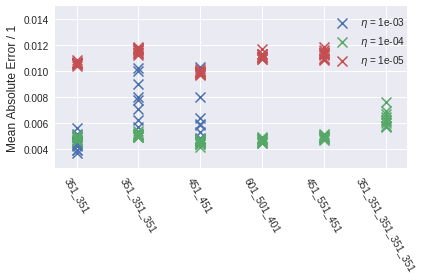

In [44]:
for r, lr in zip(res, learning_rates):
    plt.scatter(x, np.array(r).flatten(), marker="x", label="$\eta$ = {:1.0e}".format(lr) )

#plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("Mean Absolute Error / 1")

plt.xticks(
    np.arange(len(structures)),
    [structure_string(structure) for structure in structures],
    rotation=-60
)

plt.ylim(0.0025, 0.015)

plt.legend(loc='upper right',bbox_to_anchor=(1.02, 1.))
plt.tight_layout()

plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/HyperparameterStudy.pdf")

plt.show()

In [12]:
(5e-3)**2

2.5e-05